# KNN

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from termcolor import colored
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.io import arff
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV


from sklearn.neighbors import KNeighborsClassifier 
import plotly.express as px
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA



Ucitavanje podataka

In [2]:

data = pd.read_csv('/home/user/Desktop/IP/sredjeni_podaci.csv')
print(data.shape)



(8378, 123)


In [3]:
print(data['Unnamed: 0'])
data.drop('Unnamed: 0',axis = 1,inplace = True)


0          0
1          1
2          2
3          3
4          4
        ... 
8373    8373
8374    8374
8375    8375
8376    8376
8377    8377
Name: Unnamed: 0, Length: 8378, dtype: int64



Razdvajamo ciljni atribut od ostalih atributa,pa podatke delimo na trening i test skup

In [4]:
Y = data['match']
X = data.drop('match',axis = 1)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=112)

Pomocne fukcije za proveru kvaliteta modela.Kod je preuzet iz materijala sa vezbi:

In [6]:
 def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Izvestaj o klasifikaciji za model{} nad {} podacima".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    print("---------------------------------------------------------------------------------")
    
    print(colored("Matrica konfuzije za model {} nad {} podacima ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns=['1', '0'], index=['1', '0']))
    print("---------------------------------------------------------------------------------")

Pre primene KNN algoritma moramo da normalizujemo podatke, a pre toga cemo da proverimo da li postoje vrednost van granica i kako oni uticu na normalizaciju.
Za proveru vrednosti van granica koristicemo IQR.


In [7]:

def IQR(data, feature_names):
    
    iqr = pd.DataFrame(0, index=feature_names, columns=['lower', 'min', 'num_lower', 'upper', 'max', 'num_upper', 'percantage'])
    for name in feature_names:

        (Q1, Q3) = X[name].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        upper = Q3 + (1.5 * IQR)
        lower = Q1 - (1.5 * IQR)
        
        iqr.loc[name, 'upper'] = upper
        iqr.loc[name, 'lower'] = lower

        num_of_out_lower = (X[name] < lower).sum()
        num_of_out_upper = (X[name] > upper).sum()

        percentage = round((num_of_out_lower + num_of_out_upper) / X.shape[0] * 100)

        iqr.loc[name, 'num_lower'], iqr.loc[name, 'num_upper'], iqr.loc[name, 'percantage']  = num_of_out_lower, num_of_out_upper, percentage
        iqr.loc[name, 'min'], iqr.loc[name, 'max'] = min(X[name]), max(X[name])    
    return iqr

In [8]:
feature_names = X.columns
iqr = IQR(X_train,feature_names)
print(iqr)

                    lower   min  num_lower  upper   max  num_upper  percantage
wave                 -5.0   1.0          0   27.0  21.0          0           0
gender               -1.5   0.0          0    2.5   1.0          0           0
age                  18.0  18.0          0   34.0  55.0        173           2
age_o                18.0  18.0          0   34.0  55.0        173           2
d_age                -5.0   0.0          0   11.0  37.0        355           4
...                   ...   ...        ...    ...   ...        ...         ...
d_like               -1.5   0.0          0    2.5   2.0          0           0
d_guess_prob_liked   -3.0   0.0          0    5.0   2.0          0           0
met                   0.0   0.0          0    0.0   8.0        359           4
decision             -1.5   0.0          0    2.5   1.0          0           0
decision_o           -1.5   0.0          0    2.5   1.0          0           0

[121 rows x 7 columns]


Kolona pergantage nam govori koliko procenata podataka su outlieri.

In [9]:
for p in iqr['percantage']:
    if p >=1:
        print(p)
print(iqr['percantage'].max())

2
2
4
7
7
7
14
6
9
11
20
1
19
2
38
36
7
14
6
9
11
20
10
2
4
3
26
1
19
2
38
36
2
2
1
6
2
2
49
1
19
6
12
1
4
49


Na osnovu ovoga zakljucujemo da postoji veliki broj elemenata van granica (u nekoj koloni cak 49%), pa zato mislim da bi trebalo da na neki nacin outliere zamenim medijanom.

# Vizuelizacija outliera

In [32]:
df = px.data.tips()
fig = px.box(df, y="size")
fig.show()

# Normalizacija originalnih podataka i primena algoritma knn

In [11]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier()
knn.fit(X_train,Y_train)
report(knn,X_train,Y_train,text = "TRENING")
report(knn,X_test,Y_test,text = "TEST")


Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TRENING podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4898
           1       0.88      0.58      0.70       966

    accuracy                           0.92      5864
   macro avg       0.90      0.78      0.83      5864
weighted avg       0.92      0.92      0.91      5864

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad TRENING podacima 
---------------------------------------------------------------------------------
      1    0
1  4820   78
0   403  563
---------------------------------------------------------------------------------
Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TEST podacima
---------------------------------------------------------------------------------
       

Primenom algoritma KNN dobili smo tacnost od 93% na trening skupu i 88% na test skupu 

# Outliere menjamo medijanom, vrsimo normalizaciju nad izmenjenim podacima i pozivamo KNN


Proveravmao da li cemo dobiti vecu tacnost ako outliere zamenimo medijanom.

In [12]:
def replace_outliers_with_median(data):
    sortedData = np.sort(data)
    q1 = np.percentile(sortedData, 25)
    q3 = np.percentile(sortedData, 75)
    iqr = q3 - q1

    lowerBound = q1 - 3 * iqr
    upperBound = q3 + 3 * iqr

    median = np.median(data)

    replacedData = np.where(
        (data < lowerBound) | (data > upperBound),
        median,
        data
    )

    return replacedData

  

In [13]:
column_num = len(feature_names)
for i in range(0,column_num):
    column_name = feature_names[i];
    p = iqr.iat[i,6];
    if p >= 1:
        data[column_name] = replace_outliers_with_median(data[column_name])

 Pozivamo IQR da proverimo da li sada imamo outliera i u kojoj meri

In [14]:
Y = data['match'];
X = data.drop('match',axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=12)
iqr2 = IQR(X_train,feature_names)
print(iqr2['percantage'].max())

IQR(X_train,feature_names)


df = px.data.tips()
fig = px.box(df, y="size")
fig.show()


19


Kada smo jednom outliere zamenili medijanom, nismo uspeli da izgubimo sve outliere,a ako zelimo da nemamo vrednosti van granica mozemo da pozovemo vise puta istu fju.Sada radimo opet normalizaciju, pa primenu apgoritma knn

In [15]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


Dobila sam istu tacnost kao i bez ovog postupka, pa zakljucujem da outlieri ne kvare tacnost mog modela.

# PCA

Nakon sto smo normalizovali podatke, mozemo primeniti algoritam PCA sa smanjenje dimenzionalnosti naseg skupa podatka. Zelimo da smanjimo broj atributa.

In [16]:
#zelimo da objasnimo udeo varijanse do 95%
#pca = PCA(0.95)

#zelimo samo 2 glavne komponente
pca = PCA(2)

Glavne komponente su linearne kombinacije polaznih aritibuta, pca.components_
nam daje koefincijente polaznih atributa

In [17]:
pca.fit(X_train)

PCA(n_components=2)

In [18]:
pca.components_

array([[ 0.02313176, -0.35095113, -0.01848061,  0.00762508, -0.00555256,
        -0.02322459,  0.00347891,  0.01938831,  0.00248362,  0.06185033,
         0.05695695,  0.07597937,  0.0768904 ,  0.04407393,  0.05591489,
        -0.02900097, -0.01047236,  0.00756432, -0.02995014, -0.03095924,
         0.1647461 , -0.0474671 , -0.01144523,  0.03861064,  0.        ,
        -0.00996007,  0.03911835,  0.02087277,  0.00657195,  0.03199216,
         0.0044688 ,  0.03287688,  0.06678427,  0.        ,  0.        ,
         0.05739047,  0.015107  ,  0.05251698, -0.05926651,  0.01774013,
         0.00715659,  0.00236472,  0.04497358,  0.02205576, -0.16286103,
         0.02495959,  0.03329274,  0.00592505,  0.        ,  0.01314493,
         0.04254551,  0.08625526,  0.07567584,  0.02224377,  0.06556014,
         0.        ,  0.10348125,  0.12121076,  0.04134134,  0.09430783,
         0.03000207,  0.04165981,  0.07565272,  0.05386824,  0.05854092,
         0.06193239,  0.05211662,  0.        ,  0. 

Zelimo da vidimo koliko koji od polaznih atributa ima udeo u svakoj od 2 glavne komponnte

In [19]:
pca_names = [f'pca_{i}' for i in range(0,2)]
print(pca_names)

['pca_0', 'pca_1']


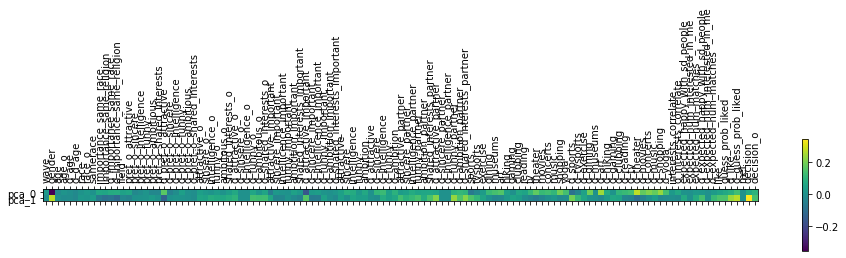

In [20]:
plt.matshow(pca.components_)
plt.xticks(ticks=range(pca.components_.shape[1]),
           labels=feature_names,rotation = 'vertical')
plt.yticks(ticks=range(pca.n_components_),
           labels=pca_names)
plt.colorbar()
plt.show()

Sada zelimo da vidimo udeo objasnjene varijanse svake od glavnih kompomenti

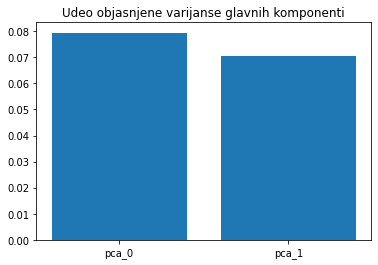

In [21]:

plt.bar(x=pca_names,
        height=pca.explained_variance_ratio_)
plt.title('Udeo objasnjene varijanse glavnih komponenti')
plt.show()


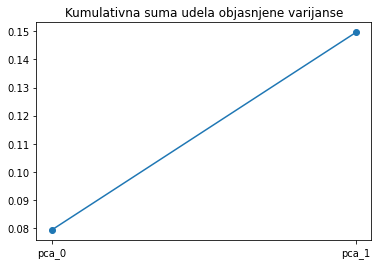

In [22]:

plt.plot(pca_names, np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Kumulativna suma udela objasnjene varijanse')
plt.show()

Objasnjeno je oko 15 % varianse podataka, 
pa mislim da sam izabrala mali broj glavnih kompomenti.
Sada pravim novi "model" gde zadajem procenat varijense koji zelim da objasnim, a to je 80%


In [23]:
pca2 = PCA(0.80)


In [24]:
pca2.fit(X_train)

PCA(n_components=0.8)

In [25]:
pca_names2 = [f'pca_{i}' for i in range(pca2.n_components_)]

In [26]:
print(pca_names2)

['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22', 'pca_23', 'pca_24', 'pca_25', 'pca_26', 'pca_27', 'pca_28', 'pca_29', 'pca_30', 'pca_31', 'pca_32', 'pca_33']




Broj glavnih komponti se povecao na 40
Ponovo zelimo da vidimo koliko koji polazni atribut ucestvuje u "izgradnji" novih atributa

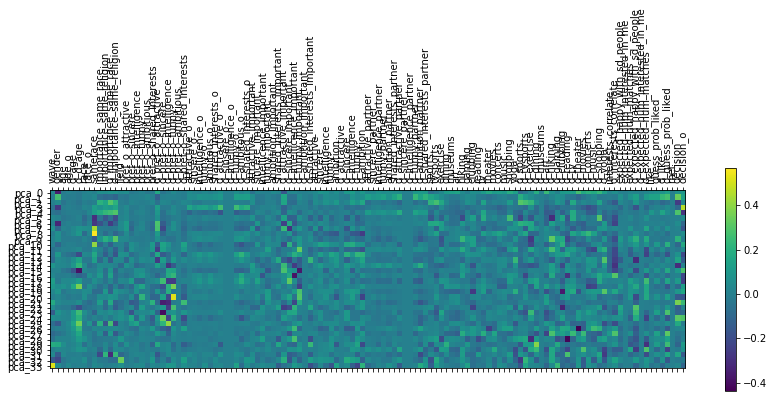

In [27]:
plt.matshow(pca2.components_)
plt.xticks(ticks=range(pca2.components_.shape[1]),
           labels=feature_names,rotation = 'vertical')
plt.yticks(ticks=range(pca2.n_components_),
           labels=pca_names2)
plt.colorbar()
plt.show()


Posmatrama kumulativnu sumu udela ubjasnjene varijanse

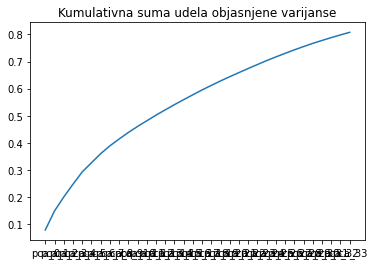

In [28]:
plt.plot(pca_names2, np.cumsum(pca2.explained_variance_ratio_))
plt.title('Kumulativna suma udela objasnjene varijanse')
plt.show()

Vidimo da smo zaista objasnili 80% varijansi.

Transformacija podataka

In [29]:
Y = data['match']
X = data.drop('match',axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=112)


X_train_pca = pca2.transform(X_train)
X_test_pca = pca2.transform(X_test)



/home/user/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but PCA was fitted without feature names

/home/user/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but PCA was fitted without feature names



# KNN 

In [30]:

knn = KNeighborsClassifier()
knn.fit(X_train_pca,Y_train)
report(knn,X_train_pca,Y_train,text = "TRENING")
report(knn,X_test_pca,Y_test,text = "TEST")



Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TRENING podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      4898
           1       0.75      0.34      0.47       966

    accuracy                           0.87      5864
   macro avg       0.82      0.66      0.70      5864
weighted avg       0.86      0.87      0.85      5864

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad TRENING podacima 
---------------------------------------------------------------------------------
      1    0
1  4789  109
0   634  332
---------------------------------------------------------------------------------
Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TEST podacima
---------------------------------------------------------------------------------
       

# Poredjenje modela ROC krivom

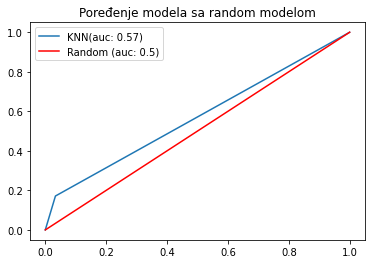

In [31]:
models = [knn]
model_names = ['KNN']
for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test_pca)
    fpr,tpr, _ = roc_curve(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)
    lab = model_name + "(auc: " + str(round(auc, 2)) + ")"
    plt.plot(fpr, tpr, label=lab)

plt.plot([0, 1], [0, 1], label='Random (auc: 0.5)', color='red')
plt.title("Poređenje modela sa random modelom")
plt.legend()
plt.show()
